# Quarta abordagem de predição: amostras equilibradas 

Equilibrio entre detratores e não-detratores (promotores + passivos):
- com validação cruzada 
- com otimização de parâmetros

## Bibliotecas e Configurações

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

## Importação dos Dados

In [2]:
df = pd.read_csv('NPS_Complete_UFF_2022-07-18_2022-12-31_extra-tratado.csv', sep=';')

display(df)

,ANF,USERVALUEQ1_LABEL,USERVALUEQ2_VALUE,vol_Rede_Social,vol_Video,vol_Comunicacao,vol_Loja_de_Apps,vol_Musica,vol_Google,vol_Navegacao,...,term_fabr_motorola,term_fabr_não informado,term_fabr_outros,term_fabr_samsung,term_fabr_xiaomi,device_tech_2G,device_tech_3G,device_tech_4G,device_tech_5G,Qtd_CRM
0,51,8,Não Informado,8.111028,6.282269,5.894406,5.347112,-6.907755,3.295874,3.295874,...,0,0,0,0,0,0,0,1,0,0
1,11,9,Plano/Bonus,7.180832,5.153297,5.283209,1.946053,-6.907755,-6.907755,-6.907755,...,0,0,0,1,0,0,0,1,0,0
2,37,10,Velocidade,8.094379,5.846442,6.682110,2.890427,4.844195,1.609638,-6.907755,...,1,0,0,0,0,0,0,1,0,0
3,81,10,Outros,4.897847,5.771444,1.386544,-6.907755,-6.907755,0.001000,-6.907755,...,0,0,1,0,0,0,1,0,0,0
4,85,10,Sinal/Cobertura,3.784212,3.434019,5.918897,1.791926,-6.907755,1.386544,-6.907755,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45201,48,0,Sinal/Cobertura,5.262695,5.398167,3.828663,5.075180,-6.907755,0.001000,-6.907755,...,0,0,0,0,1,0,0,1,0,0
45202,35,7,Sinal/Cobertura,7.978654,6.054442,7.756196,3.912043,-6.907755,3.401231,-6.907755,...,0,0,0,1,0,0,0,1,0,0
45203,43,10,Duracao pacote dados,3.434019,5.332724,4.248510,1.386544,-6.907755,-6.907755,-6.907755,...,1,0,0,0,0,0,0,0,1,0
45204,42,10,Sinal/Cobertura,-6.907755,5.159061,1.386544,-6.907755,-6.907755,-6.907755,-6.907755,...,0,0,0,1,0,0,1,0,0,0


### Notas atribuídas (distribuição)

In [3]:
df['USERVALUEQ1_LABEL'].value_counts() # divisão de clientes por nota atribuída

10    18937
8      5477
9      4578
0      4099
7      2879
5      2756
6      1684
1      1438
3      1202
2      1147
4      1009
Name: USERVALUEQ1_LABEL, dtype: int64

# Machine Learning

### Bibliotecas

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

### Train Test Split

In [5]:
# Amostrar 70% para treino e 30% para teste
df_train = df.sample(frac=0.7, random_state=1)
df_test = df.drop(df_train.index)

In [6]:
df_train.value_counts('NPS_Class_Detrator') # divisão de clientes por nota atribuída

NPS_Class_Detrator
0    22266
1     9378
dtype: int64

In [7]:
# pegar amostras iguais de cada classe em NPS_Class_Detrator
df_train = df_train.groupby('NPS_Class_Detrator').apply(lambda x: x.sample(n=9000)).reset_index(drop=True)

In [8]:
# Separar os dados de treino em X e y
X_train = df_train.drop(columns=['USERVALUEQ1_LABEL', 'USERVALUEQ2_VALUE', 'NPS_Class_Detrator', 'NPS_Class_Passivo', 'NPS_Class_Promotor'])
y_train = df_train['NPS_Class_Detrator']

# Separar os dados de teste em X e y
X_test = df_test.drop(columns=['USERVALUEQ1_LABEL', 'USERVALUEQ2_VALUE', 'NPS_Class_Detrator', 'NPS_Class_Passivo', 'NPS_Class_Promotor'])
y_test = df_test['NPS_Class_Detrator']

### XGBoost

In [9]:
xgb = XGBClassifier(objective='binary:hinge')
xgb.get_params()

{'objective': 'binary:hinge',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [10]:
hyper_dict = {
    "colsample_bytree": uniform(0.7, 0.3), # percentual de colunas a serem amostradas para cada árvore (colunas)
    "learning_rate": uniform(0.03, 0.3), # taxa de aprendizado 
    "max_depth": randint(4, 8), # profundidade máxima de cada árvore
    "n_estimators": randint(100, 250), # número de árvores
    "subsample": uniform(0.5, 0.9) # percentual de amostras a serem usadas para cada árvore (linhas)
}

search_cv = RandomizedSearchCV(xgb, param_distributions=hyper_dict, n_iter=10, scoring='f1', random_state=0)
search_cv.fit(X_train, y_train)

c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\luiza\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", lin

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A8456890>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A8457E50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A84560B0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161A8455D50>},
                   random_state=0, scoring='f1')

In [11]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'colsample_bytree': 0.9871465476859138, 'learning_rate': 0.07210523412379355, 'max_depth': 4, 'n_estimators': 182, 'subsample': 0.9262472407463395}


In [12]:
best_model_xgb = search_cv.best_estimator_
best_model_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9871465476859138, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07210523412379355,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=182, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [13]:
y_pred = best_model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.47      0.58      9605
           1       0.34      0.66      0.45      3957

    accuracy                           0.53     13562
   macro avg       0.55      0.57      0.52     13562
weighted avg       0.64      0.53      0.54     13562



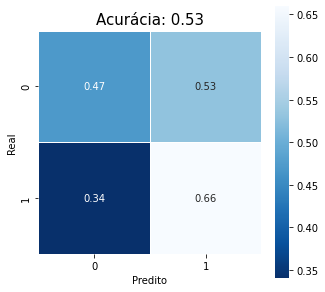

In [15]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Real');
plt.xlabel('Predito');
all_sample_title = 'Acurácia: {:.2f}'.format(best_model_xgb.score(X_test, y_test))
plt.title(all_sample_title, size = 15);
plt.rcParams.update({'font.size': 10})
plt.show()

# salvar em pdf
#plt.savefig('plots/xgb_cm_amostras_todos.pdf')

In [16]:
# feature importance
feature_importances = pd.DataFrame(best_model_xgb.feature_importances_,
                                    index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                           importance
qtde_celula                  0.048629
vol_4g_perc                  0.048552
vol_MarketPlace              0.039143
vol_Navegacao                0.033029
VoLTE_perc                   0.030604
CUSTOMER_SEGMENT_Controle    0.030120
Qtd_CRM                      0.028223
CUSTOMER_SEGMENT_Pré-pago    0.027258
dias_franquia_zerada         0.023817
ANF                          0.022555
vol_TIM                      0.021009
eficiencia_Voz               0.020454
eficiencia_pdp               0.020169
dias_traf_red                0.019498
vol_Alimentacao              0.019254
tot_volume                   0.019241
FLAG_EXISTENCIA_R            0.019218
vol_Musica                   0.018607
device_tech_4G               0.018529
term_fabr_lg                 0.017764
device_tech_5G               0.017723
tot_chamada                  0.017476
vol_Rede_Social              0.017398
DISP_STATUS_p                0.017240
originada_perc               0.017202
vol_Transpor

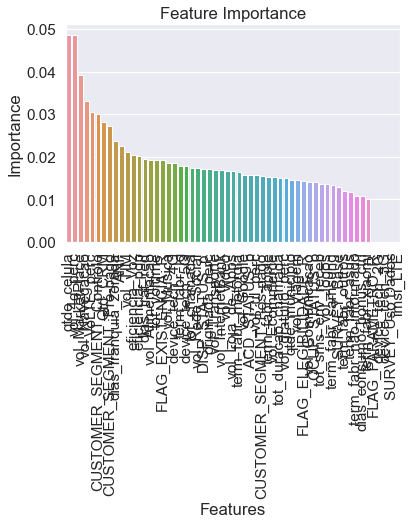

In [18]:
# histograma das features mais importantes
sns.set_style('white')
sns.set(font_scale=1.4)
sns.barplot(x=feature_importances.index, y=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Salvar em pdf
#plt.savefig('plots/xgb_feature_importance.pdf')

### Random Forest

In [19]:
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [20]:
hyper_dict = {
    "max_depth": randint(4, 8), # profundidade máxima de cada árvore
    "n_estimators": randint(100, 250), # número de árvores
    "min_samples_leaf": randint(2, 15), # número mínimo de amostras em cada folha
    "max_features": randint(2, 10) # número máximo de features a serem consideradas em cada árvore
}

search_cv = RandomizedSearchCV(rf, param_distributions=hyper_dict, n_iter=10, scoring='f1', random_state=0)
search_cv.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161B9DEACB0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161B9FEE140>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001618661B4F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000161B9FED5A0>},
                   random_state=0, scoring='f1')

In [21]:
print("Best params:")
print(search_cv.best_params_)

Best params:
{'max_depth': 7, 'max_features': 8, 'min_samples_leaf': 10, 'n_estimators': 181}


In [22]:
best_model_rf = search_cv.best_estimator_
best_model_rf

RandomForestClassifier(max_depth=7, max_features=8, min_samples_leaf=10,
                       n_estimators=181)

In [24]:
y_pred = best_model_rf.predict(X_test)
print(classification_report(y_test, y_pred))
'''cr = classification_report(y_test, y_pred, output_dict=True)
print(cr)

# limitar a 2 casas decimais
for key in cr.keys():
    if key != 'accuracy':
        cr[key] = {k: round(v, 2) for k, v in cr[key].items()}

# salvar em excel
cr_df = pd.DataFrame(cr).transpose()
cr_df.to_csv('tables/rf_cr_amostras_iguais.csv', index=False)'''

              precision    recall  f1-score   support

           0       0.76      0.59      0.67      9605
           1       0.36      0.56      0.44      3957

    accuracy                           0.58     13562
   macro avg       0.56      0.57      0.55     13562
weighted avg       0.64      0.58      0.60     13562



"cr = classification_report(y_test, y_pred, output_dict=True)\nprint(cr)\n\n# limitar a 2 casas decimais\nfor key in cr.keys():\n    if key != 'accuracy':\n        cr[key] = {k: round(v, 2) for k, v in cr[key].items()}\n\n# salvar em excel\ncr_df = pd.DataFrame(cr).transpose()\ncr_df.to_csv('tables/rf_cr_amostras_iguais.csv', index=False)"

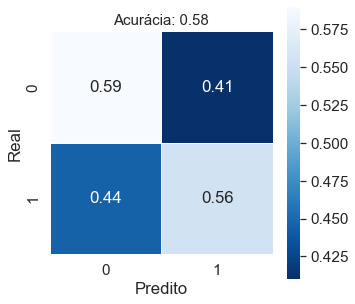

In [26]:
# matriz de confusão
cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=0.5, square = True, cmap = 'Blues_r');
plt.ylabel('Real');
plt.xlabel('Predito');
all_sample_title = 'Acurácia: {:.2f}'.format(best_model_rf.score(X_test, y_test))
plt.title(all_sample_title, size = 15);
plt.show()

# salvar em pdf
#plt.savefig('plots/rf_cm_amostras_todos.pdf')

In [27]:
# feature importance
feature_importances = pd.DataFrame(best_model_rf.feature_importances_,
                                    index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                           importance
qtde_celula                  0.072221
VoLTE_perc                   0.052599
vol_4g_perc                  0.045183
vol_Navegacao                0.043217
vol_Rede_Social              0.042750
ANF                          0.041624
vol_MarketPlace              0.038158
eficiencia_Voz               0.037377
tot_volume                   0.036177
tot_chamada                  0.035898
tot_sms_env_receb            0.029837
eficiencia_pdp               0.029734
tot_duracao_chamada          0.029502
originada_perc               0.027958
vol_Video                    0.027580
vol_Musica                   0.026185
vol_Loja_de_Apps             0.025561
vol_Comunicacao              0.024956
dias_franquia_zerada         0.024288
qtde_municipio               0.022643
vol_Google                   0.022100
DISP_STATUS_p                0.021757
CUSTOMER_SEGMENT_Pré-pago    0.021341
CUSTOMER_SEGMENT_Controle    0.019822
Qtd_CRM                      0.019565
OCUP_STATUS_

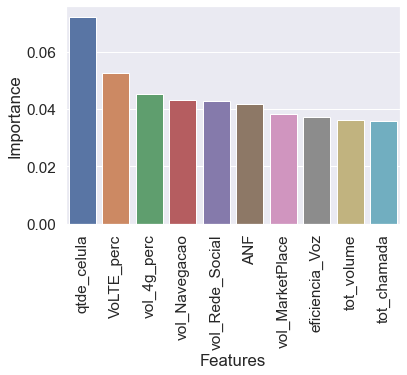

In [29]:
# histograma das features mais importantes - exbir apenas top 10 features
sns.set_style('white')
sns.set(font_scale=1.4)
sns.barplot(x=feature_importances.index[:10], y=feature_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

#salvar em pdf
#plt.tight_layout()
#plt.savefig('plots/rf_fi_amostras_todos.pdf')